This notebook includes a first sketch of the ShorelineNet implementation in pytorch. 

In particular I want to achieve the following: 
* config loading
* network saving & loading
* try to wrap everything in classes
* where possible, use type annotations
* experiment with MC dropout & posterior estimation

15 Jan: loaded images

16 Jan: augmentation pipeline

17 Jan: Create network architecture & load pre-trained encoder

18 Jan: Set up loss function & training loop

In [3]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import os
import sys

from tqdm.notebook import tqdm
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch import ones_like, zeros_like
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# append local module to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# load MaSTr dataset
mastr_path = '../../project_offline/Dataset/MaSTr1325/'

In [4]:
# import local modules
from utils.transforms import *
from helper.visualization import *
from utils.mastr_dataset import MastrDataset
from model.unet_mobilenetv2 import Unet_MobileNetV2, Unet_MobileNetV2_Decoder, Encoder_feature_extractor

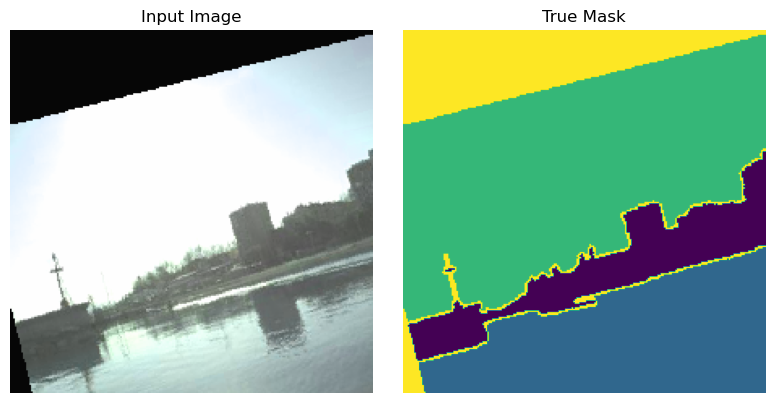

In [5]:
# define transformations 
custom_transforms = transforms.Compose([
    ToTensor(),
    HFlip(prob=0.5),
    Rotation(15, prob=1),
    HueSatCon(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, prob=1),
    Crop(0.8),
    Resize((224, 224)),
])

dataset = MastrDataset(os.path.join(mastr_path, 'images'),
                       os.path.join(mastr_path, 'masks'),
                       custom_transforms)

train_dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

sample = next(iter(train_dataloader))

imgs, labels = sample['image'], sample['mask']
img_displayer = ImageDisplayer(imgs, labels)
img_displayer.show_sample(idx=0)


### Encoder definition

In [6]:
mobileNetWeights = torchvision.models.MobileNet_V2_Weights
mobileNet = torchvision.models.mobilenet_v2(weights=mobileNetWeights)

# remove unused layers
mobileNet.features[-1] = nn.Identity()
mobileNet.classifier = nn.Identity()

# print(mobileNet)


/Users/leonyao/opt/anaconda3/envs/SNet_torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# summary(mobileNet, (3, 224, 224))

In [8]:
feature_extractor = Encoder_feature_extractor(mobileNet)

# dummy forward pass
dummy_input = torch.rand((2, 3, 224, 224))

out = mobileNet(dummy_input)

print(out.shape)

for (key, value) in feature_extractor.features.items():
    print(f'{key}: {value.shape}')

torch.Size([2, 320])
skip_1: torch.Size([2, 96, 112, 112])
skip_2: torch.Size([2, 144, 56, 56])
skip_3: torch.Size([2, 192, 28, 28])
skip_4: torch.Size([2, 576, 14, 14])
skip_5: torch.Size([2, 320, 7, 7])


### Decoder Definition

### UNET definition

In [9]:
encoder = mobileNet
decoder = Unet_MobileNetV2_Decoder()
unet = Unet_MobileNetV2(encoder, decoder)

# unet

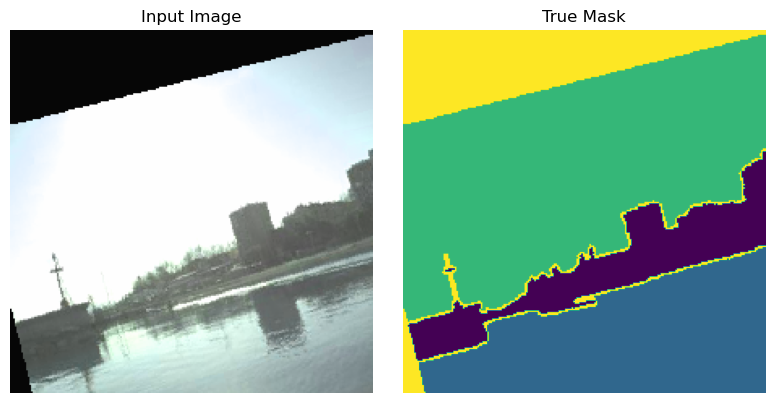

In [10]:
img_displayer.show_sample(0)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


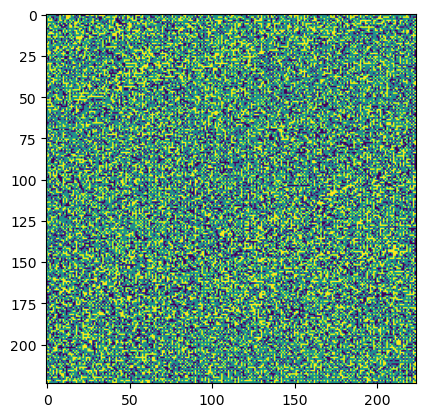

In [11]:
plt.imshow(torch.argmax(unet(imgs[0:1])[0], dim=0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


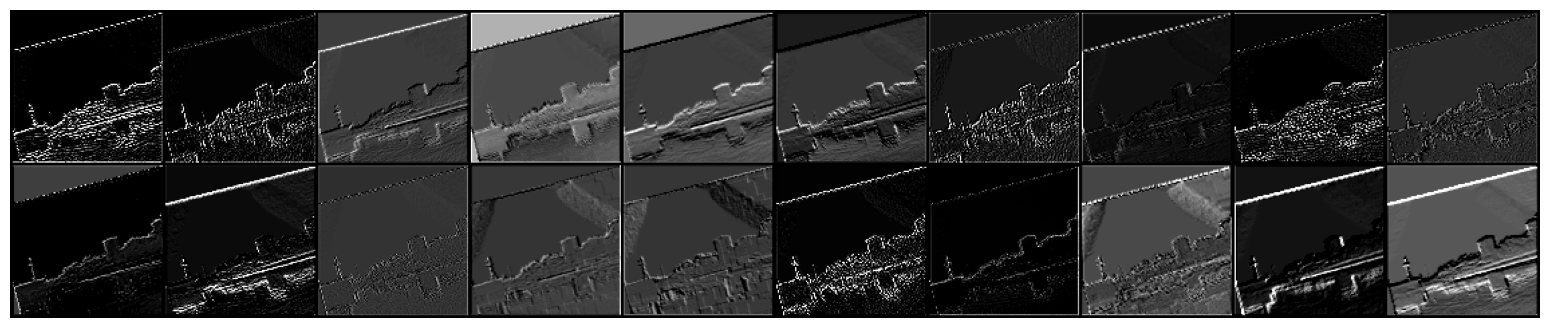

In [12]:
show_features(feature_extractor.features['skip_1'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


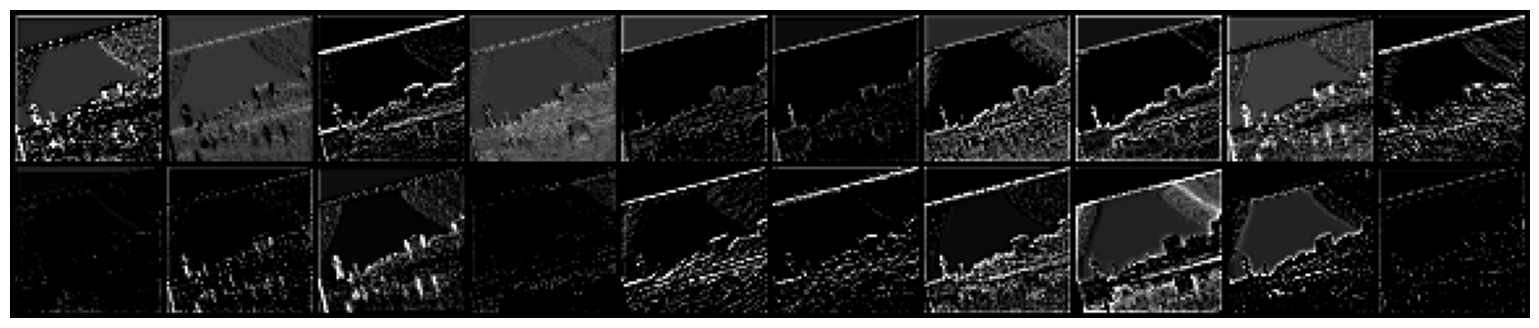

In [13]:
show_features(feature_extractor.features['skip_2'])

### Loss function definition 

In [ ]:
# Testing loss functions

y_pred = torch.tensor([[1, 0, 0], [0.5, 0.5, 0.], [0.5, 0.5, 0], [1, 0, 0]], dtype=float)
y_pred_correct = torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]], dtype=float)

y_target = torch.tensor([0, 0, 0, 0], dtype=float)
# BCE_loss = nn.functional.cross_entropy(y_pred, y_target)
y_target_one_hot = nn.functional.one_hot(y_target.long(), num_classes=3).float()
BCE_loss = nn.functional.binary_cross_entropy_with_logits(
    y_pred_correct, y_target_one_hot)
focalLoss = torchvision.ops.sigmoid_focal_loss(y_pred, y_target_one_hot, reduction='sum')

print(BCE_loss)
print(focalLoss)

print(y_pred.shape)
print(y_target_one_hot.shape)
# print(torch.sigmoid(y_pred))


In [14]:
def Focal_loss(y_true, y_pred):
    mask = torch.where(y_true == 3.0, zeros_like(y_true), ones_like(y_true))
    y_true *= mask 
    y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=3).float().permute(0, 3, 1, 2)

    mask = mask.unsqueeze(dim=1)
    # print(y_pred.shape)
    # print(mask.shape)
    y_pred *= mask
    # TODO: double that gradients will not flow through to masked pixels

    loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='sum')

    return loss

print(Focal_loss(y_target, y_pred))


NameError: name 'y_target' is not defined

In [ ]:
history = []
N_epochs = 10

encoder = mobileNet
decoder = Decoder()
unet = Unet(encoder, decoder)

opt = torch.optim.Adam(unet.parameters())

for epoch in range(N_epochs):
    train_loss = 0.0
    for item in train_dataloader:
        X, y = item['image'], item['mask'].squeeze()
        y_pred = unet(X)
        loss = Focal_loss(y, y_pred)
        loss.backward()
        opt.step()
        print("Epoch %d, train loss = %0.4f" % (epoch, loss))
    history.append(train_loss)
